## Purpose of this Notebook

This notebook is an exploration of 22 days of CO2 data that I gathered in January and February of 2021 to investigate the diurnal nature of the CO2 cycle. After data analysis I then simulated a box model to show how this diurnal cycle can be attributed to atmospheric planetry boundary layer dynamics and sources and sinks of CO2 in the Portland region. 

In [16]:
#modules used in this notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Part 1: Analysis of the CO2 Data

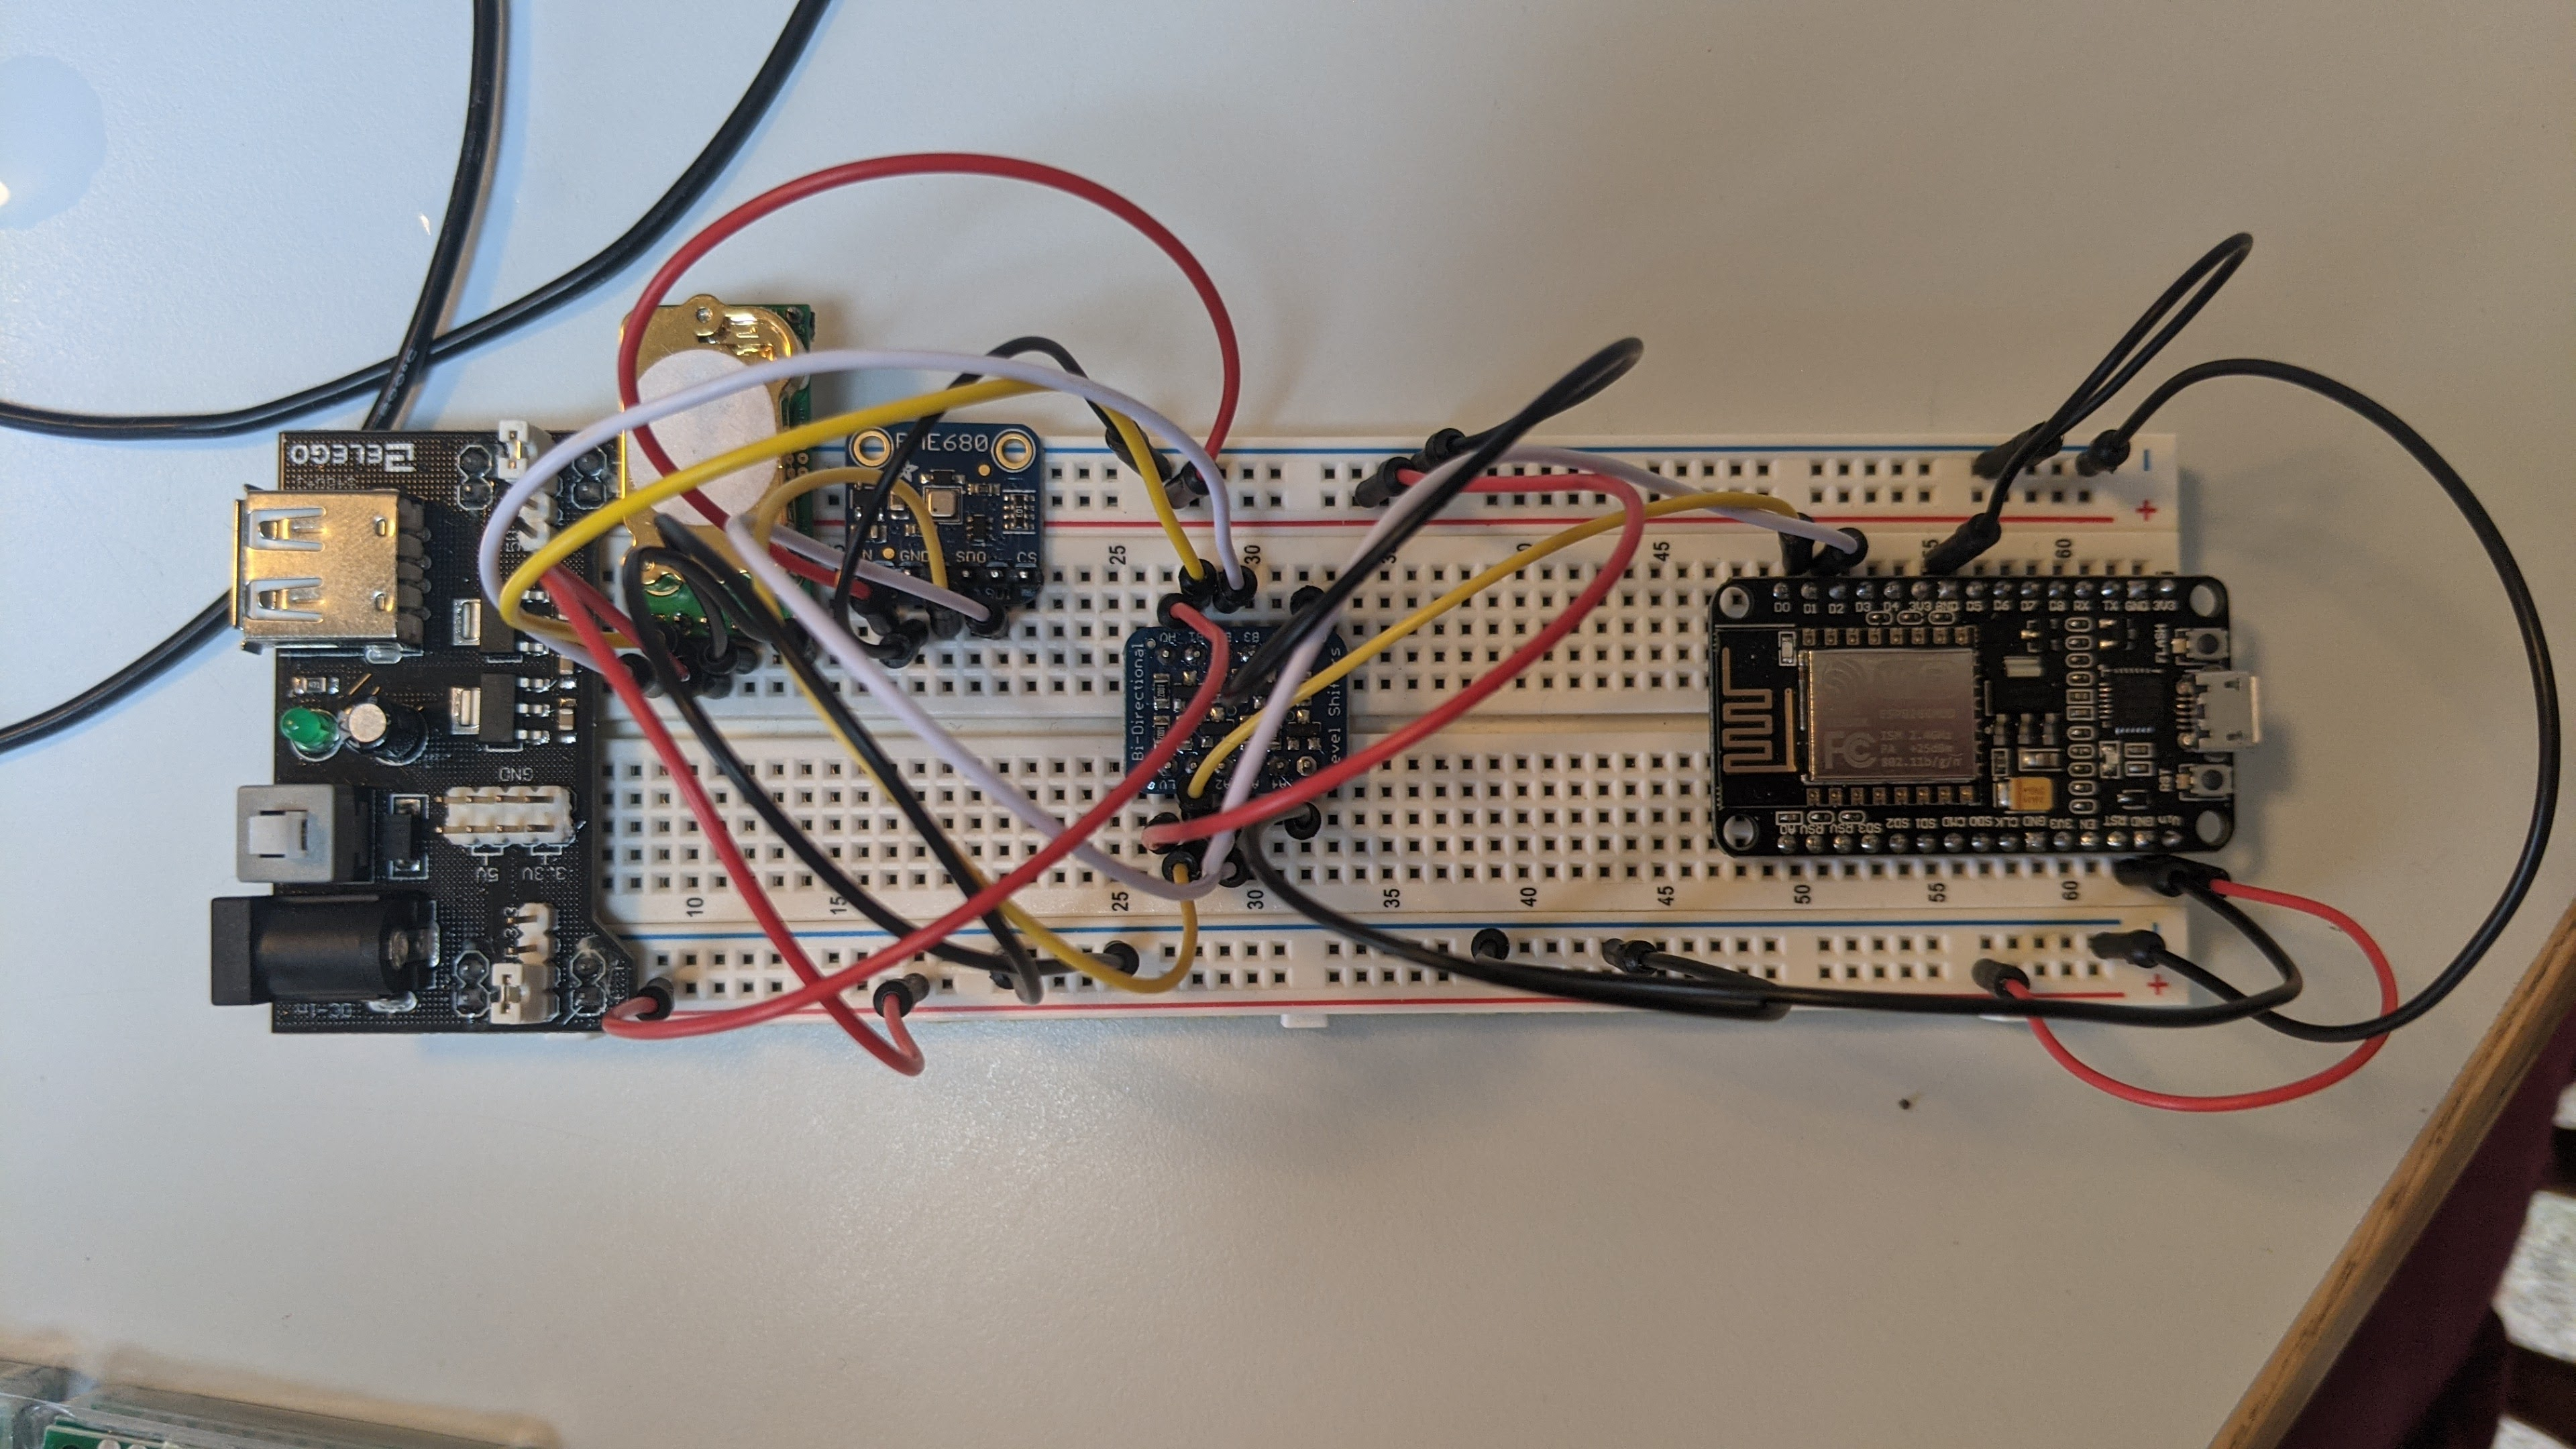

I started by reading in a pre-processed file called with 22 days of CO2 concentration data taken every 15 seconds and averaged to be stored as a data point every 1 minute. 

In [2]:
co2 = pd.read_csv('CO2_Data.csv')
co2.head()

,Time,mqtt_consumer.mean
0,2021-01-20 10:21:00,485 ppm
1,2021-01-20 10:22:00,497 ppm
2,2021-01-20 10:23:00,507 ppm
3,2021-01-20 10:24:00,502 ppm
4,2021-01-20 10:25:00,499 ppm


Next I cleaned up the data, removed NaN value

In [3]:
co2['Time'] = co2.loc[:,'Time'].apply(pd.to_datetime) #convert col 0 from obj to datetime
co2 = co2.dropna() #drop na values
co2['ppm'] = co2.loc[:,'mqtt_consumer.mean'].str.extract('(\d+)').astype(int)
del co2['mqtt_consumer.mean'] #delete redundant column
co2.head()

,Time,ppm
0,2021-01-20 10:21:00,485
1,2021-01-20 10:22:00,497
2,2021-01-20 10:23:00,507
3,2021-01-20 10:24:00,502
4,2021-01-20 10:25:00,499


In [4]:
co2['Day'] = co2.loc[:,'Time'].dt.strftime('%m%d').astype(int) #used for getting daily mean

def dec_time(Time): #decimal value of an entire day
    Hour = Time.dt.strftime('%H').astype(int)
    Minute_60 = Time.dt.strftime('%M').astype(int)
    Minute = Minute_60/60
    return Hour + Minute

co2['DecTime'] = dec_time(co2.Time)
co2.head()

,Time,ppm,Day,DecTime
0,2021-01-20 10:21:00,485,120,10.350000
1,2021-01-20 10:22:00,497,120,10.366667
2,2021-01-20 10:23:00,507,120,10.383333
3,2021-01-20 10:24:00,502,120,10.400000
4,2021-01-20 10:25:00,499,120,10.416667


In [5]:
DayMean = co2[['Day','ppm']]
DayMean = DayMean.groupby('Day').mean()
DayMean = DayMean.reset_index()

In [6]:
co2 = pd.merge(co2, DayMean, on = 'Day', how= 'inner')
co2 = co2.rename(columns = {'ppm_x':'ppm', 'ppm_y':'DailyMean'})

In [7]:
co2['anomaly'] = co2.ppm - co2.DailyMean
co2.head()

,Time,ppm,Day,DecTime,DailyMean,anomaly
0,2021-01-20 10:21:00,485,120,10.350000,509.604396,-24.604396
1,2021-01-20 10:22:00,497,120,10.366667,509.604396,-12.604396
2,2021-01-20 10:23:00,507,120,10.383333,509.604396,-2.604396
3,2021-01-20 10:24:00,502,120,10.400000,509.604396,-7.604396
4,2021-01-20 10:25:00,499,120,10.416667,509.604396,-10.604396


In [8]:
mean = co2.anomaly.mean()
std = co2.anomaly.std()
co2['zscore'] = co2.anomaly/std
co2 = co2.loc[co2.zscore.abs()<=2.5]
co2.head()

,Time,ppm,Day,DecTime,DailyMean,anomaly,zscore
0,2021-01-20 10:21:00,485,120,10.350000,509.604396,-24.604396,-0.919169
1,2021-01-20 10:22:00,497,120,10.366667,509.604396,-12.604396,-0.470874
2,2021-01-20 10:23:00,507,120,10.383333,509.604396,-2.604396,-0.097295
3,2021-01-20 10:24:00,502,120,10.400000,509.604396,-7.604396,-0.284084
4,2021-01-20 10:25:00,499,120,10.416667,509.604396,-10.604396,-0.396158


Text(0.5, 1.0, 'Concentration of CO2 in Troutdale for 22 Days')

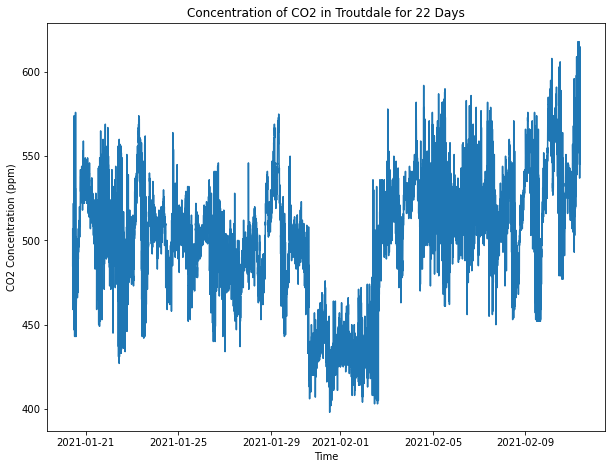

In [9]:
plt.figure(figsize=(10,7.5))
plt.plot(co2.Time, co2.ppm)
plt.xlabel('Time')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('Concentration of CO2 in Troutdale for 22 Days')

The data points that were 3 standard deviations away from the daily mean were discarded and the mean was calculated and stored in daily_mean for each individual day. I then calculated the anomaly values by subtracting the daily mean from the recorded ppm value. The plot below shows the anomaly values of all 22 days and the time of the day they were recorded in. 

Text(0, 0.5, 'CO2 Anomaly from Daily Mean (ppm)')

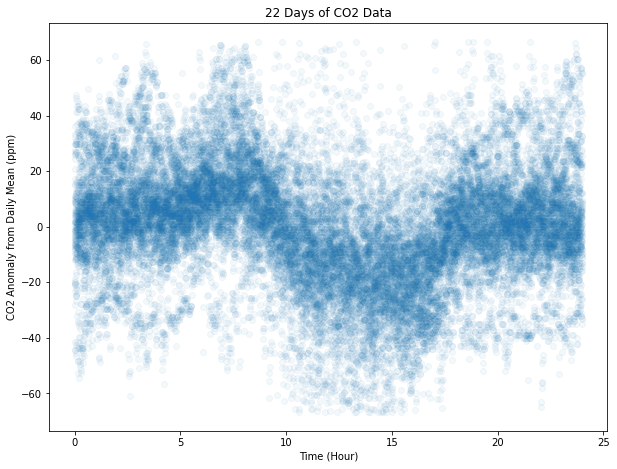

In [10]:
plt.figure(figsize = (10,7.5))
plt.scatter(co2.DecTime, co2.anomaly, alpha = .05)
plt.title("22 Days of CO2 Data")
plt.xlabel("Time (Hour)")
plt.ylabel("CO2 Anomaly from Daily Mean (ppm)")

Taking the mean value of each datapoint for each minute better shows the diurnal cycle of CO2 as well as cuts down on the data points needed for the running the fast fourier transform later.

Text(0, 0.5, 'CO2 Anomaly from Daily Mean (ppm)')

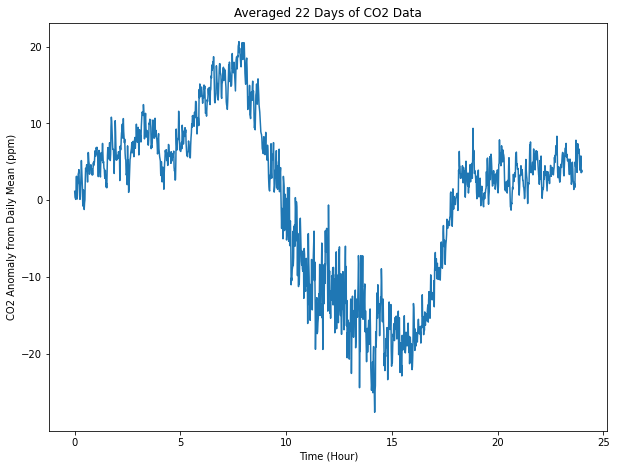

In [11]:
means = co2[['DecTime','anomaly']]
means = means.groupby('DecTime').mean()
means = means.reset_index()

plt.figure(figsize = (10,7.5))
plt.plot(means.DecTime,means.anomaly)
plt.title("Averaged 22 Days of CO2 Data")
plt.xlabel("Time (Hour)")
plt.ylabel("CO2 Anomaly from Daily Mean (ppm)")

The 22 day averaged CO2 curve was then repeated 50 times to give the fast fourier transform adequate datapoints to do a sinusoidal fit. 

class:  ndarray
shape:  (72000,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1dbe82cf030
byteorder:  little
byteswap:  False
type: float64


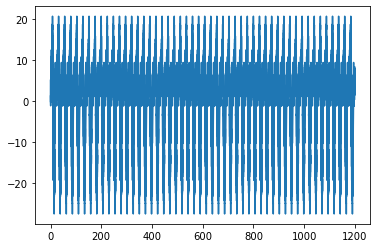

In [12]:
means_time = np.linspace(0,24*50,1440*50)
means_ppm = np.array(means.anomaly)

means_ppm_tile = np.tile(means_ppm, 50)
np.info(means_ppm_tile)
plt.plot(means_time, means_ppm_tile)

The fft shows harmonics at every 50 x axis tick marks. This is no coincidence, there should be a harmonic every 50 because I repeated the CO2 data 50 times. Each harmonic just adds to the complexity of the wave.

F:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 1000.0)

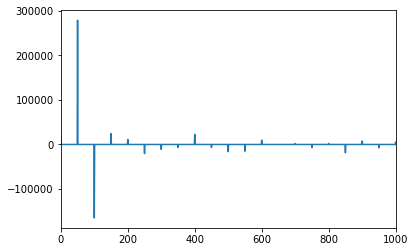

In [13]:
fft = np.fft.rfft(means_ppm_tile)
plt.plot(fft)
plt.xlim(0,1000)

For simplicity's sake, I filtered out everything but the first two harmonics to get a very simple yet still insightful curve.

F:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[-164948.39381077+216383.00648268j       0.             +0.j
   16613.63113246     +0.j          278909.42628154-319994.39169456j]


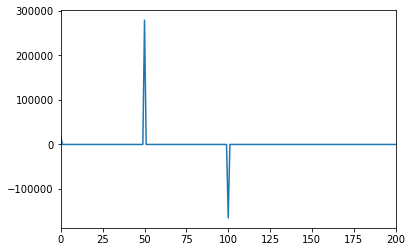

In [14]:
for i in range(len(fft)):
    if abs(fft[i]) < 1e-6:
        fft[i] = 0
    elif i < 150:
        pass
    
    else:
        fft[i] = 0

plt.plot(fft)
plt.xlim(0,200)
print(np.unique(fft))

Taking the inverse of the fft shows that there is a good fit between the mean anomaly values of the CO2 data and the fft. The fft shows the diurnal nature of CO2 and how it peaks in the early morning, just before the sun comes up and is at its lowest point during the hottest and sunniest part of the day. There is a strange feature that is shown by the fft of a bump in CO2 at about 9pm-10pm that is intersting, although I am limited in my understanding to thoroughly explain it. 

(0.0, 24.0)

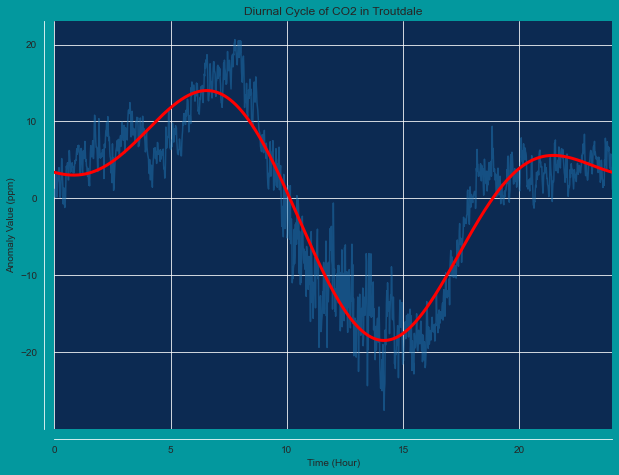

In [20]:
ifft = np.fft.irfft(fft)
sns.set_style("darkgrid", {"axes.facecolor": "#0c2a52"})
plt.figure(figsize=(10,7.5), facecolor = "#03989e")
plt.plot(means_time, means_ppm_tile, label = "Mean of Anomaly Values", alpha = .5)
plt.plot(means_time, ifft, label = "2 Harmonic Fast Fourier Transform", color = 'red', lw = 3)
plt.title("Diurnal Cycle of CO2 in Troutdale")
plt.xlabel("Time (Hour)")
plt.ylabel("Anomaly Value (ppm)")
sns.despine(offset=10, trim=False)
plt.xlim(0,24)

# Part  2: Box Model Simulation of the Diurnal Cycle of CO2

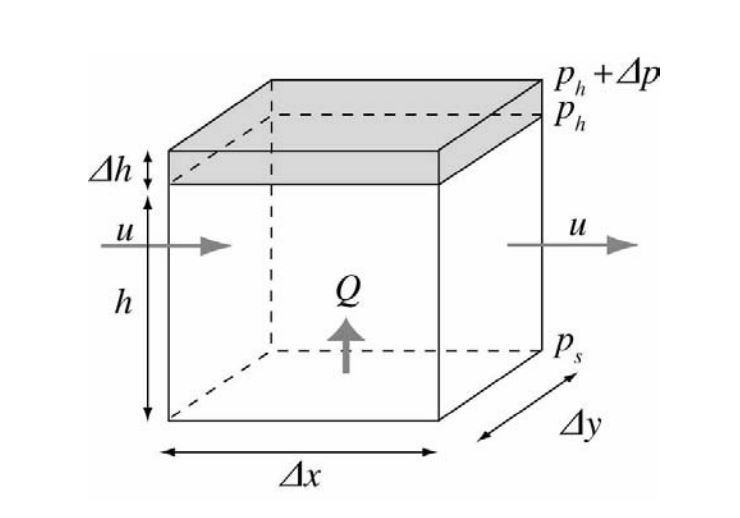

The differential equation that I used for the box model was provided by Shuhei Ono of MIT. 

## $$ \frac{dC_{bl}}{dt} = \frac{q(t)}{h(t)} + \frac{1}{\tau}(C_{up} - C_{bl}) + \frac{1}{h(t)} \frac{dh}{dt}(C_{ent} - C_{bl}) $$

Where,

$C_{bl}$: CO2 concentration in mol/m^3 for planetary boundary layer.

$C_{up}$: CO2 concentration in mol/m^3, for upwind box

$C_{ent}$: CO2 concentration in mol/m^3 above boundary layer

$\Delta x and \Delta y$: lateral length of the box (m)

$q$: emission rate in mol/sec

$u$: wind speed to the box in m/s

$h$: boundary layer height in m

$\tau$: residence time $\frac{\Delta x}{u}$

These are all the variables and a few lambda functions that are used throughout the notebook. 

In [ ]:
Q = 19.4e6 #metric tons of CO2 per 1 year (2019)

anthropogenic = Q*1e6/44/524380/365.25/24/60/60 #Mt*tons to grams/grams to mols/area of portland///year to seconds (mol m^-2 s^-1)

dy = 724.141 #19377.8 #length of box (m)
dx = dy #width of box
Cup_ppm= 410#CO2 concentration for upwind box
Cent_ppm = 410#CO2 concentration above boundary layer
u = 3#wind speed in m/s
tau = dy/u #residence time of air over the area of the box (lateral length of box / wind speed)

ppm_to_mol = lambda x: x/10**6*44.01/.0224*1e-6
mol_to_ppm = lambda x: x*10**6/44.01*.0224*1e6
Cup_mol = ppm_to_mol(Cup_ppm)
Cent_mol = ppm_to_mol(Cent_ppm)
sec_to_hour = lambda x: x/60/60

a = 0
b = 5e5
N = 1000
h = (b - a)/N
dhdt = 1e-6


Below is a very basic function for the rate at which photosynthesis occurs during only the daytime. It is based on my own current understanding of how photosynthesis works and is not supposed to be a rigorous analysis of the photosynthesis cycle during the day. I also did not account for respiration of plants in the model since it happens constantly and can be lumped in with the constant anthropogenic factors. I also did not take into account rush hour times in the model since there were no clear spikes during rush hour time in the gathered data.

In [ ]:
def photosynthesis(t):
    value = np.sin(2*np.pi/86400*t-.75*np.pi)
    if value < 0:
        return 0
    else:   
        return value

tpoints = np.arange(a,b,h)
tpoints_hour = [sec_to_hour(i) for i in tpoints]

photo_points = [photosynthesis(i) for i in tpoints]
photo_points_hour = [sec_to_hour(i) for i in photo_points]

plt.figure(figsize=(10,7.5))
plt.plot(tpoints_hour, photo_points)
plt.xlim(0,24)
plt.xlabel('Time (Hours)')
plt.ylabel('Photosynthesis %')
plt.title('Approximated Percent Photosynthesis Occuring')

This is the fourth order harmonic function that describes the height of the boundary layer. It was also provided by the MIT worksheet by Shuhei Ono. The graph was originally inverted and was about 500 meters higher than the what it is currently. However, given that it was winter when this was recorded and the boundary layer rises at night, I feel that my adjustments were warranted. 

In [ ]:
def harmonic(t):
    m = 4
    ak = [75.2235, -29.1925, -7.4486, 1.9185]
    bk = [62.8391, 8.0102, 6.5066, -11.6844]
    a0 = 500
    sum = 0
    for i in range(m):
        sum -= ak[i]*np.sin(2*np.pi*(i+1)*t/(24)) + bk[i]*np.cos(2*np.pi*(i+1)*t/(24))
    sum += a0
    return sum 

hours_to_seconds = lambda x: x*60*60
t = np.linspace(0,24,1000)
t_seconds = [hours_to_seconds(i) for i in t]
harmonic_seconds = [harmonic(i) for i in t]
plt.figure(figsize=(10,7.5))
plt.plot(t, harmonic_seconds)
plt.xlabel("Time (Hour)")
plt.ylabel("Altitude (meters)")
plt.title("Boundary Layer Height")

This is the differential equation that I will be applying the runge kutta method on. It accounts for anthropogenic and photosynthesis in carbon creation, wind moving the CO2 into and out of the box, and an entrainment factor. 

In [ ]:
def CO2(Cbl,t):
    q = anthropogenic #- anthropogenic*photosynthesis(t)
    return q/harmonic(t/60/60) + 1/tau*(Cup_mol - Cbl) + 1/harmonic(t/60/60)*dhdt*(Cent_mol-Cbl)

Below is the runge kutta method I used to evaluate the differential equation. It is a fixed step size equation which I felt was adequate given the simplicity of the project and the fact that it is a first order differential equation. Evaluated, it shows the diurnal cycle of CO2 as it fluctuates almost 8 ppm. Compared to the 30 ppm that the actual data fluctuated this doesn't seem like much, but it does definitely show how the cycle of CO2 is diurnal. 

In [ ]:
xpoints = []
x = ppm_to_mol(417.5)

for t in tpoints:
    xpoints.append(x)
    k1 = h*CO2(x,t)
    k2 = h*CO2(x+0.5*k1,t+0.5*h)
    k3 = h*CO2(x+0.5*k2,t+0.5*h)
    k4 = h*CO2(x+k3,t+h)
    x += (k1+2*k2+2*k3+k4)/6  

xpoints_ppm = [mol_to_ppm(i) for i in xpoints]
tpoints_hour = [sec_to_hour(i) for i in tpoints]

plt.figure(figsize=(10,7.5))   
plt.plot(tpoints_hour,xpoints_ppm)
plt.xlim(0,24)
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration CO2 (ppm)')
plt.title('Concentration of CO2 over 1 Day')

## Works Cited



Ono, Shuhei. Box Model for CO2 in an Urban Atmosphere, MIT OCW, Oct. 2013, ocw.mit.edu/courses/earth-atmospheric-and-planetary-sciences/12-335-experimental-atmospheric-chemistry-fall-2014/labs/MIT12_335F14_Box_model.pdf. 

Rice, Andrew, and Gregory Bostrom. “Measurements of Carbon Dioxide in an Oregon Metropolitan Region.” Atmospheric Environment, vol. 45, no. 5, 2011, pp. 1138–1144., doi:10.1016/j.atmosenv.2010.11.026. 

Xueref-Remy, Irène, et al. “Diurnal, Synoptic and Seasonal Variability of Atmospheric CO2 in the Paris Megacity Area.” Atmospheric Chemistry and Physics, vol. 18, no. 5, 2018, pp. 3335–3362., doi:10.5194/acp-18-3335-2018. 

Zhang, Yuanjie, et al. “Diurnal Climatology of Planetary Boundary Layer Height Over the Contiguous United States Derived From AMDAR and Reanalysis Data.” Journal of Geophysical Research: Atmospheres, vol. 125, no. 20, 2020, doi:10.1029/2020jd032803. 